In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    log_loss,
    roc_curve,
    auc,
    precision_recall_curve,
)
from sklearn.calibration import calibration_curve

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
train_data = pd.read_parquet("../data/unadultered/train_data.parquet")
test_data = pd.read_parquet("../data/unadultered/test_data.parquet").reset_index()

In [3]:
def clean_data(data = train_data, debug=True, y_value =True,):
    """Cleans data given in test_data schema

    Args:
        data (test_data schema, optional): Just the typical input data, accepts test_data and train_data. Defaults to test_data.

    Returns:
        _type_: the same train_data database with the appropriate datatypes
    """
    cleaned_data = data
    for col_num in range(1, 367):
        col = "f" + str(col_num)
        print(col+":") if debug else None
        # These columns have strings hence we want to change or drop them soon
        if col_num in [42, 50] + list(range(52, 57)):
            print("pass") if debug else None
            pass
        elif col_num in list(range(226, 310)) + list(range(332, 336)) + [359, 360]:
            cleaned_data[col] = data[col].astype(bool)
            print("bool") if debug else None
        else:
            col_data = pd.to_numeric(
                data[col], errors="coerce"
            )  # converts to numeric, keeps NaN
            # Check if any non-NaN value has decimal part
            if (col_data.dropna() % 1 != 0).any():
                cleaned_data[col] = col_data.astype(float)
                print("bool") if debug else None
            else:
                cleaned_data[col] = col_data.astype("Int64")
                print("Int") if debug else None
                
    # Lastly converting the y-values
    cleaned_data["y"] = data["y"].astype("Int64") if y_value else None
    # Dropping columns that have strings in their values as not yet worked around.
    cleaned_data = cleaned_data.drop(["f42","f50","f52","f53","f54","f55","f56"],axis=1)
    # Filling all the NaN values with 0
    cleaned_data = cleaned_data.fillna(0)
    return cleaned_data

In [4]:
# cleaned Training Data
clean_train_data = clean_data(data=train_data,debug=False,y_value=True)
clean_test_data = clean_data(data=test_data,debug=False,y_value=True)

C:\Users\rohan\AppData\Local\Temp\ipykernel_17196\1744062663.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cleaned_data["y"] = data["y"].astype("Int64") if y_value else None
C:\Users\rohan\AppData\Local\Temp\ipykernel_17196\1744062663.py:38: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cleaned_data = cleaned_data.fillna(0)


In [ ]:
# Separate out the y and X from each case
# Splitting the data into the Xdata and Ydata
# Training data
X_train = clean_train_data.iloc[:,6:]
y_train = clean_train_data.iloc[:,5]
# Testing data
X_test = clean_test_data.iloc[:,6:]

In [8]:
X_train.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f357,f358,f359,f360,f361,f362,f363,f364,f365,f366
0,1,0,0,0,0,0,0,0,0,13,...,0.0,-9999.0,True,False,28,0,0.00000,337,0,0.00000
1,1,0,0,0,0,0,0,0,0,13,...,0.0,0.0,True,False,87,0,0.00000,1010,2,0.00198
2,1,0,0,0,0,0,0,0,0,13,...,0.0,0.0,True,False,23,0,0.00000,1010,2,0.00198
3,1,0,0,0,0,0,0,0,0,13,...,0.0,-9999.0,True,False,277,1,0.00361,337,0,0.00000
4,1,0,0,0,0,0,0,0,0,13,...,0.0,-9999.0,True,False,359,0,0.00000,337,0,0.00000


## Model fitting

In [7]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

base_model = SGDClassifier(loss='log_loss',class_weight="balanced", random_state=42)
model = CalibratedClassifierCV(base_model, method='sigmoid', cv=5)

model.fit(X_train, y_train)

,estimator,SGDClassifier...ndom_state=42)
,method,'sigmoid'
,cv,5
,n_jobs,None
,ensemble,'auto'
,loss,'log_loss'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000


---

## testing out the model

In [8]:
y_pred_proba = model.predict_proba(X_test)[:, 1]
print("AUC:", roc_auc_score(y_test, y_pred_proba))
print("Log Loss:", log_loss(y_test, y_pred_proba))

AUC: 0.7482615753889266
Log Loss: 0.18151869588389002


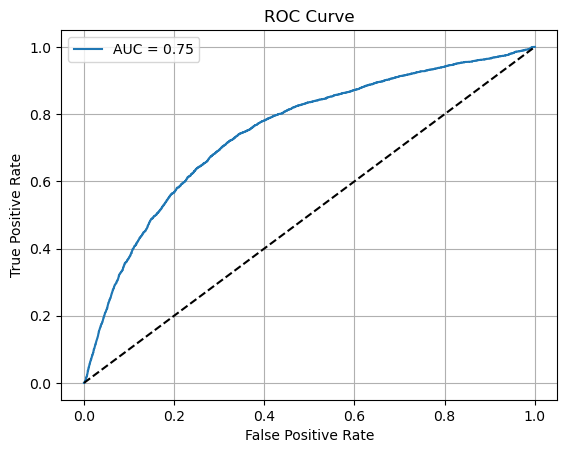

In [9]:
# ROC Curve (Receiver Operating Characteristic)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

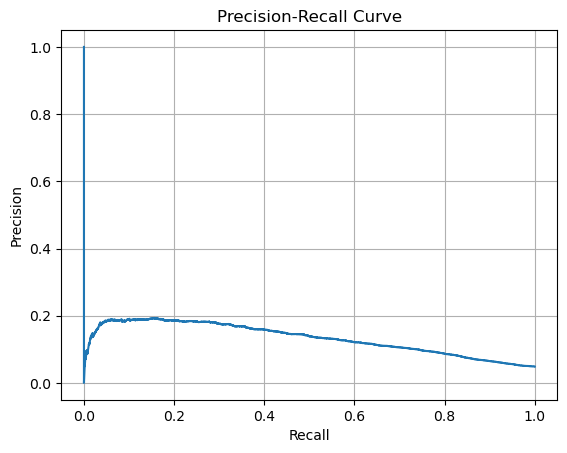

In [10]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

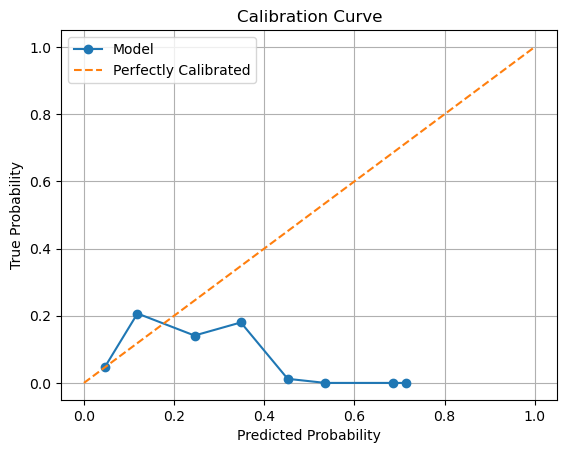

In [11]:
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)

plt.plot(prob_pred, prob_true, marker='o', label='Model')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Curve')
plt.legend()
plt.grid(True)
plt.show()

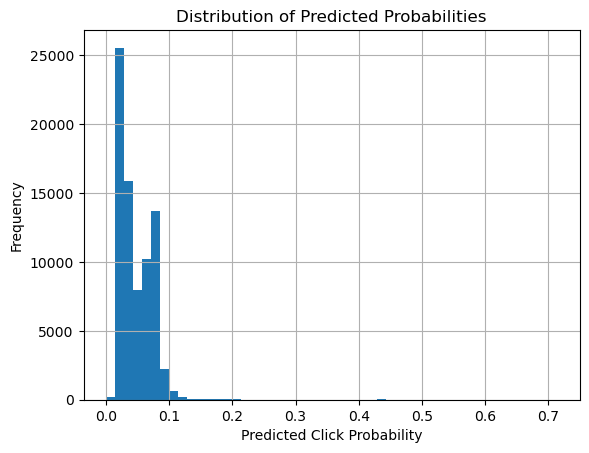

In [12]:
plt.hist(y_pred_proba, bins=50)
plt.xlabel('Predicted Click Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities')
plt.grid(True)
plt.show()

---
## predicting the new probability values

In [20]:
# Using the cleaned test data to figure out the probabilities of clicks
X_clean_test = clean_test_data.iloc[:,6:].drop("y",axis=1)
y_pred_proba_test = model.predict_proba(X_clean_test)[:, 1]

In [22]:
df_click_probs = pd.DataFrame({"click_probabability": y_pred_proba_test})
df_click_probs.to_csv('click_probabilities_sgdc.csv', index=False)

In [19]:
clean_test_data.head()

,index,id1,id2,id3,id4,id5,f1,f2,f3,f4,...,f358,f359,f360,f361,f362,f363,f364,f365,f366,y
0,46756,1362907_91950_16-23_2023-11-04 18:56:26.000794,1362907,91950,2023-11-04 18:56:26.000794,2023-11-04,0,0,0,0,...,0.046600,True,False,1,0,0.000000,56,0,0.000000,0
1,57819,1082599_88356_16-23_2023-11-04 06:08:53.373,1082599,88356,2023-11-04 06:08:53.373,2023-11-04,0,9,0,0,...,0.060309,True,False,195,13,0.066667,0,0,0.000000,0
2,15390,1888466_958700_16-23_2023-11-05 10:07:28.000725,1888466,958700,2023-11-05 10:07:28.000725,2023-11-05,0,0,0,0,...,0.073484,True,False,155,67,0.432258,1142,436,0.381786,0
3,145730,1888971_795739_16-23_2023-11-04 12:25:28.244,1888971,795739,2023-11-04 12:25:28.244,2023-11-04,0,0,0,0,...,0.040572,True,False,0,0,0.000000,0,0,0.000000,0
4,146085,1256369_82296_16-23_2023-11-05 06:45:26.657,1256369,82296,2023-11-05 06:45:26.657,2023-11-05,0,0,0,0,...,0.038244,True,False,29,2,0.068966,361,3,0.008310,0
